## Sequence prediction using recurrent neural networks(LSTM)

based on: http://mourafiq.com/2016/05/15/predicting-sequences-using-rnn-in-tensorflow.html

Using TensorFlow to predict continous functions:
- sin, cos

In [34]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error

%pylab inline

#from tensorflow.python.ops import rnn, rnn_cell

HOME = os.environ['HOME']

Populating the interactive namespace from numpy and matplotlib


#### Aux Functions

In [7]:

def rnn_data(data, time_steps, labels=False):
    """
    creates new data frame based on previous observation
      * example:
        l = [1, 2, 3, 4, 5]
        time_steps = 2
        -> labels == False [[1, 2], [2, 3], [3, 4]]
        -> labels == True [2, 3, 4, 5]
    """
    rnn_df = []
    for i in range(len(data) - time_steps):
        if labels:
            try:
                rnn_df.append(data.iloc[i + time_steps].as_matrix())
            except AttributeError:
                rnn_df.append(data.iloc[i + time_steps])
        else:
            data_ = data.iloc[i: i + time_steps].as_matrix()
            rnn_df.append(data_ if len(data_.shape) > 1 else [[i] for i in data_])
    return np.array(rnn_df)


def split_data(data, val_size=0.1, test_size=0.1):
    """
    splits data to training, validation and testing parts
    """
    ntest = int(round(len(data) * (1 - test_size)))
    nval = int(round(len(data.iloc[:ntest]) * (1 - val_size)))

    df_train, df_val, df_test = data.iloc[:nval], data.iloc[nval:ntest], data.iloc[ntest:]

    return df_train, df_val, df_test


def prepare_data(data, time_steps, labels=False, val_size=0.1, test_size=0.1):
    """
    Given the number of `time_steps` and some data,
    prepares training, validation and test data for an lstm cell.
    """
    df_train, df_val, df_test = split_data(data, val_size, test_size)
    return (rnn_data(df_train, time_steps, labels=labels),
            rnn_data(df_val, time_steps, labels=labels),
            rnn_data(df_test, time_steps, labels=labels))

def generate_data(fct, x, time_steps, seperate=False):
    """generates data with based on a function fct"""
    data = fct(x)
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)
    train_x, val_x, test_x = prepare_data(data['a'] if seperate else data, time_steps)
    train_y, val_y, test_y = prepare_data(data['b'] if seperate else data, time_steps, labels=True)
    return dict(train=train_x, val=val_x, test=test_x), dict(train=train_y, val=val_y, test=test_y)

#### LSTM Model

In [27]:
def lstm_model(num_units, rnn_layers, dense_layers=None, 
               learning_rate=0.1, optimizer='Adagrad'):
    """
    Creates a deep model based on:
        * stacked lstm cells
        * an optional dense layers
    :param num_units: the size of the cells.
    :param rnn_layers: list of int or dict
                         * list of int: the steps used to instantiate the `BasicLSTMCell` cell
                         * list of dict: [{steps: int, keep_prob: int}, ...]
    :param dense_layers: list of nodes for each layer
    :return: the model definition
    """

    def lstm_cells(layers):
        if isinstance(layers[0], dict):
            return [tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.BasicLSTMCell(
                        layer['num_units'], state_is_tuple=True), layer['keep_prob'])
                    if layer.get('keep_prob') else tf.nn.rnn_cell.BasicLSTMCell(
                    layer['num_units'], state_is_tuple=True) for layer in layers]
        return [tf.nn.rnn_cell.BasicLSTMCell(steps, state_is_tuple=True) for steps in layers]

    def dnn_layers(input_layers, layers):
        if layers and isinstance(layers, dict):
            return learn.ops.dnn(input_layers,
                                 layers['layers'],
                                 activation=layers.get('activation'),
                                 dropout=layers.get('dropout'))
        elif layers:
            return learn.ops.dnn(input_layers, layers)
        else:
            return input_layers

    def _lstm_model(X, y):
        stacked_lstm = tf.nn.rnn_cell.MultiRNNCell(lstm_cells(rnn_layers), state_is_tuple=True)
        x_ = tf.unpack(X, axis=1, num=num_units)
        output, layers = tf.nn.rnn(stacked_lstm, x_, dtype=tf.nn.dtypes.float64)
        output = dnn_layers(output[-1], dense_layers)
        prediction, loss = tf.contrib.learn.models.linear_regression(output, y)
        train_op = tf.contrib.layers.optimize_loss(
            loss, tf.contrib.framework.get_global_step(), optimizer=optimizer,
            learning_rate=learning_rate)
        return prediction, loss, train_op

    return _lstm_model

#### Prepare Data

In [28]:
LOG_DIR = HOME + '/data/tf_tut/logs/sin'
TIMESTEPS = 3
RNN_LAYERS = [{'num_units': 5}]
DENSE_LAYERS = None
TRAINING_STEPS = 10000
PRINT_STEPS = TRAINING_STEPS / 10
BATCH_SIZE = 100

In [29]:
regressor = tf.contrib.learn.Estimator(
    model_fn=lstm_model(TIMESTEPS, RNN_LAYERS, DENSE_LAYERS), model_dir=LOG_DIR)

## Predicting sin() Function

In [30]:
X, y = generate_data(np.sin, np.linspace(0, 100, 10000), TIMESTEPS, seperate=False)
# create a lstm instance and validation monitor
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(X['val'], y['val'],
                                                      every_n_steps=PRINT_STEPS,
                                                      early_stopping_rounds=1000)
regressor.fit(X['train'], y['train'], 
              monitors=[validation_monitor], 
              batch_size=BATCH_SIZE,
              steps=TRAINING_STEPS)

Estimator(params=None)

In [31]:
predicted = regressor.predict(X['test'])
rmse = np.sqrt(((predicted - y['test']) ** 2).mean(axis=0))
score = mean_squared_error(predicted, y['test'])
print ("MSE: %f" % score)

MSE: 0.000146


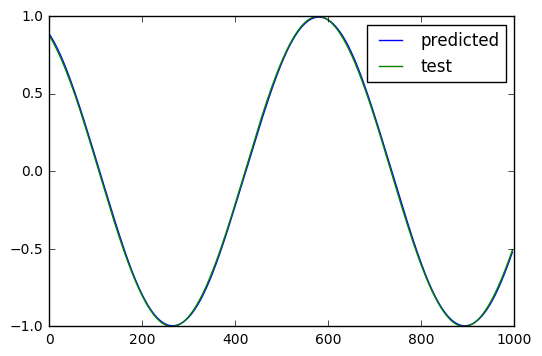

In [35]:
plot_predicted, = plt.plot(predicted, label='predicted')
plot_test, = plt.plot(y['test'], label='test')
plt.legend(handles=[plot_predicted, plot_test])

## Predicting sin() - cos() Functions together

In [37]:
LOG_DIR = HOME + '/data/tf_tut/logs/sin_cos'
TIMESTEPS = 5
RNN_LAYERS = [{'num_units': 5}, {'num_units': 2}]
DENSE_LAYERS = None
TRAINING_STEPS = 10000
PRINT_STEPS = TRAINING_STEPS / 10
BATCH_SIZE = 100

In [39]:
regressor = tf.contrib.learn.Estimator(model_fn=lstm_model(TIMESTEPS, RNN_LAYERS, DENSE_LAYERS),
                            model_dir=LOG_DIR)

In [40]:
def sin_cos(x):
    return pd.DataFrame(dict(a=np.sin(x), b=np.cos(x)), index=x)

In [42]:
X, y = generate_data(sin_cos, np.linspace(0, 100, 10000), TIMESTEPS, seperate=False)
# create a lstm instance and validation monitor
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(X['val'], y['val'],
                                                      every_n_steps=PRINT_STEPS,
                                                      early_stopping_rounds=1000)
regressor.fit(X['train'], y['train'], 
              monitors=[validation_monitor], 
              batch_size=BATCH_SIZE,
              steps=TRAINING_STEPS)

Estimator(params=None)

In [43]:
predicted = regressor.predict(X['test'])
rmse = np.sqrt(((predicted - y['test']) ** 2).mean(axis=0))
score = mean_squared_error(predicted, y['test'])
print ("MSE: %f" % score)


MSE: 0.000023


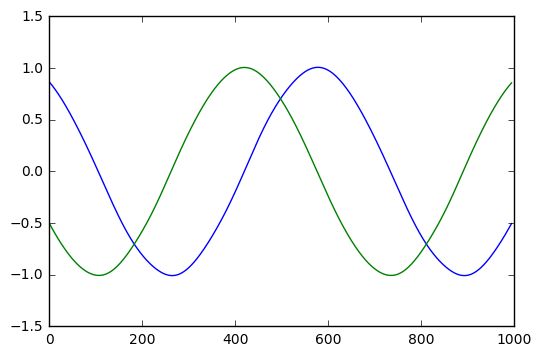

In [45]:
plt.plot(predicted)

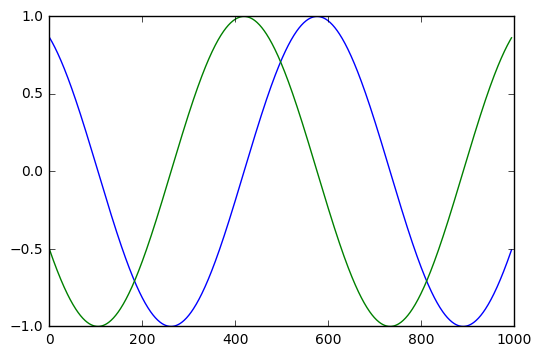

In [44]:
plt.plot(y['test'])

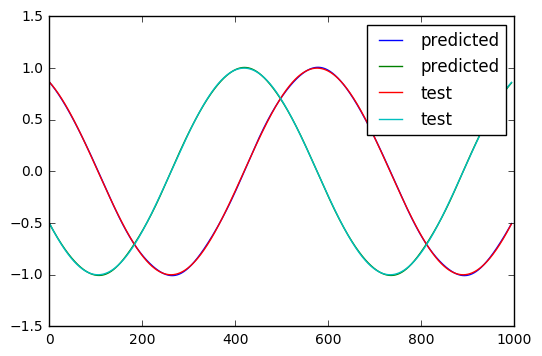

In [46]:
plot_predicted = plt.plot(predicted, label='predicted')
plot_test = plt.plot(y['test'], label='test')
plt.legend(handles=plot_predicted+plot_test)

## Predicting x*sin() Function

Note: in order to capture larger and larger outputs, the number of training steps needs to be increased.

In [66]:
LOG_DIR = HOME + '/data/tf_tut/logs/xsin'
TIMESTEPS = 10
RNN_LAYERS = [{'num_units': 10}, {'num_units': 5}]
DENSE_LAYERS = None
TRAINING_STEPS = 30000 # 100000
PRINT_STEPS = TRAINING_STEPS / 10
BATCH_SIZE = 100

In [67]:
regressor = tf.contrib.learn.Estimator(model_fn=lstm_model(TIMESTEPS, RNN_LAYERS, DENSE_LAYERS),
                            model_dir=LOG_DIR)

In [68]:
def x_sin(x):
    return x * np.sin(x)

In [69]:
X, y = generate_data(x_sin, np.linspace(0, 100, 10000), TIMESTEPS, seperate=False)
# create a lstm instance and validation monitor
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(X['val'], y['val'],
                                                      every_n_steps=PRINT_STEPS,
                                                      early_stopping_rounds=10000)
regressor.fit(X['train'], y['train'], 
              monitors=[validation_monitor], 
              batch_size=BATCH_SIZE,
              steps=TRAINING_STEPS)

Estimator(params=None)

MSE: 1.093457


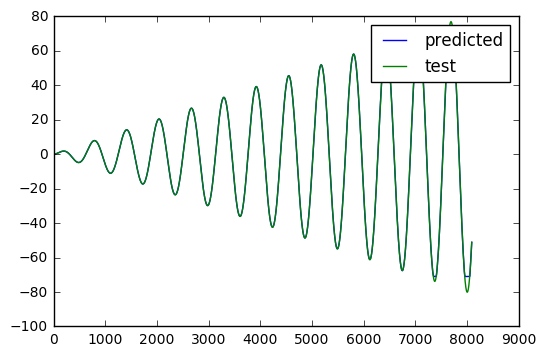

In [70]:
x_true, y_true = X['test'], y['test']
x_true, y_true = X['val'], y['val']
x_true, y_true = X['train'], y['train']

predicted = regressor.predict(x_true)
rmse = np.sqrt(((predicted - y_true) ** 2).mean(axis=0))
score = mean_squared_error(predicted, y_true)
print ("MSE: %f" % score)

plt.plot(predicted, label='predicted')
plt.plot(y_true, label='test')
plt.legend()

MSE: 15.296748


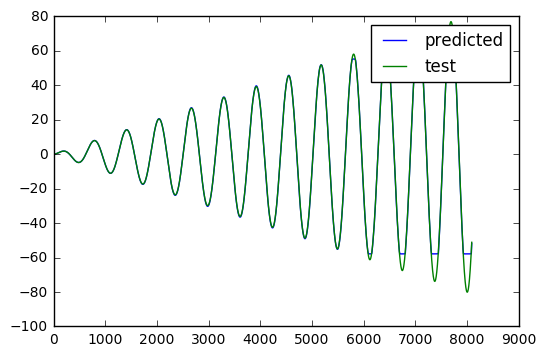

In [65]:
x_true, y_true = X['test'], y['test']
x_true, y_true = X['val'], y['val']
x_true, y_true = X['train'], y['train']

predicted = regressor.predict(x_true)
rmse = np.sqrt(((predicted - y_true) ** 2).mean(axis=0))
score = mean_squared_error(predicted, y_true)
print ("MSE: %f" % score)

plt.plot(predicted, label='predicted')
plt.plot(y_true, label='test')
plt.legend()

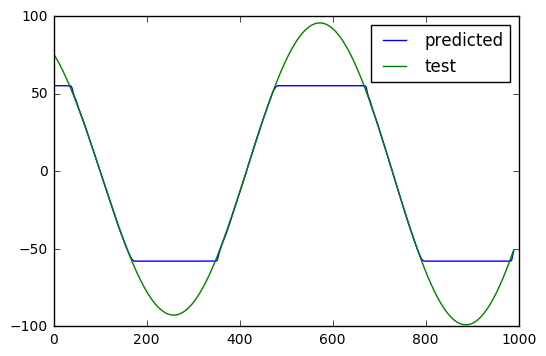

In [ ]:
plt.plot(regressor.predict(X['train']))
plt.plot(y['train'])